<a href="https://colab.research.google.com/github/sgywhetstone/CholletDLWorkbooks/blob/master/CholletC4IMDBClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Improving on the C3 IMBD classification model by using dropout and weight regularization 

First we experiment with larger and smaller models to see the effects of over/underfitting. Finding the existing size to be a reasonable compromise, we test different versions of regularization and dropout rates, before training a final model using both. 

Regularization and dropout interact in some way creating a strange effect on validation scores. Nonetheless, the final model improves accuracy from 85% to 87.5%.

In [1]:
#Using the code from C3, prepare the dataset and generate the old model

import keras
import numpy as np
keras.__version__

#Set the number of words we keep from the reviews - e.g. if max_words = 10000, we keep only the top 10 000 most common words
max_words = 10000

from keras.datasets import imdb

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words= max_words)

# restore np.load for future normal usage
np.load = np_load_old

#Encode the reviews via one-hot encoding
def vectorize_sequences(sequences, dimension = max_words):  #One-hot function
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

#Vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

#Vectorize training and test labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


#Create a 10k sample validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Using TensorFlow backend.


In [2]:
#Old Model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(max_words,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

W0717 22:06:48.955657 139943469377408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 22:06:48.972837 139943469377408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 22:06:48.975090 139943469377408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 22:06:49.034674 139943469377408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 22:06:49.052309 139943469377408 deprecation_wrappe

In [0]:
#Smaller Model
small_model = models.Sequential()
small_model.add(layers.Dense(4, activation='relu', input_shape=(max_words,)))
small_model.add(layers.Dense(4, activation='relu'))
small_model.add(layers.Dense(1, activation='sigmoid'))

small_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [0]:
#Larger Model
large_model = models.Sequential()
large_model.add(layers.Dense(512, activation='relu', input_shape=(max_words,)))
large_model.add(layers.Dense(512, activation='relu'))
large_model.add(layers.Dense(1, activation='sigmoid'))

large_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [5]:
#Train models and collect validation data

model_hist = model.fit(partial_x_train, partial_y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_val, y_val))

small_model_hist = small_model.fit(partial_x_train, partial_y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_val, y_val))

large_model_hist = large_model.fit(partial_x_train, partial_y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_val, y_val))

W0717 22:06:49.398211 139943469377408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 171us/step - loss: 0.5093 - acc: 0.7849 - val_loss: 0.3894 - val_acc: 0.8571
Epoch 2/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.3039 - acc: 0.9003 - val_loss: 0.3044 - val_acc: 0.8876
Epoch 3/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2170 - acc: 0.9287 - val_loss: 0.3133 - val_acc: 0.8751
Epoch 4/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.1708 - acc: 0.9433 - val_loss: 0.2810 - val_acc: 0.8892
Epoch 5/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.1400 - acc: 0.9549 - val_loss: 0.2829 - val_acc: 0.8888
Epoch 6/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.1162 - acc: 0.9638 - val_loss: 0.3142 - val_acc: 0.8786
Epoch 7/20
15000/15000 [==============================] - 1s 89us/step - loss: 0.0954 - acc: 0.9722 - val_loss: 0.3172 - val_ac

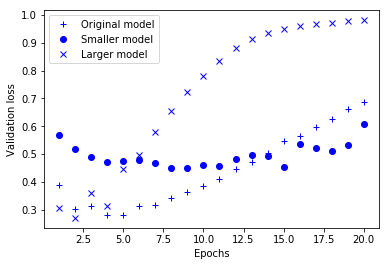

In [6]:
#Plotting validation loss for all 3 models

epochs = range(1, 21)
original_val_loss = model_hist.history['val_loss']
small_model_val_loss = small_model_hist.history['val_loss']
large_model_val_loss = large_model_hist.history['val_loss']

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, small_model_val_loss, 'bo', label='Smaller model')
# "bx" is for "blue x"
plt.plot(epochs, large_model_val_loss, 'bx', label='Larger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


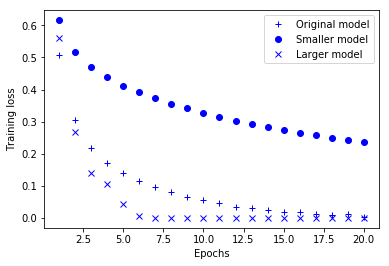

In [7]:
#Plotting training loss for all 3 models

epochs = range(1, 21)
original_train_loss = model_hist.history['loss']
small_model_train_loss = small_model_hist.history['loss']
large_model_train_loss = large_model_hist.history['loss']

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_train_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, small_model_train_loss, 'bo', label='Smaller model')
# "bx" is for "blue x"
plt.plot(epochs, large_model_train_loss, 'bx', label='Larger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

Now we use regularization to the model - see notes for a discussion of regularization and kernel methods. 

We compare validation losses from original model with regularized version using three different regularizers. 

In [8]:
#Creating model with L1 regularization
from keras import regularizers

l1_model = models.Sequential()
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

#Creating model with L2 regularization
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

#Creating model with L1/L2 regularization
from keras import regularizers

l1_l2_model = models.Sequential()
l1_l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation='relu', input_shape=(10000,)))
l1_l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(0.001), activation='relu'))
l1_l2_model.add(layers.Dense(1, activation='sigmoid'))

#Compile models
l1_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l1_model_hist = l1_model.fit(partial_x_train, partial_y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))

l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2_model_hist = l2_model.fit(partial_x_train, partial_y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))

l1_l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l1_l2_model_hist = l1_l2_model.fit(partial_x_train, partial_y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_val, y_val))


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 114us/step - loss: 1.0784 - acc: 0.7393 - val_loss: 0.7707 - val_acc: 0.7206
Epoch 2/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6846 - acc: 0.8335 - val_loss: 0.6549 - val_acc: 0.8478
Epoch 3/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6260 - acc: 0.8531 - val_loss: 0.6169 - val_acc: 0.8542
Epoch 4/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.5967 - acc: 0.8548 - val_loss: 0.5960 - val_acc: 0.8546
Epoch 5/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.5728 - acc: 0.8627 - val_loss: 0.5864 - val_acc: 0.8556
Epoch 6/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.5572 - acc: 0.8641 - val_loss: 0.5643 - val_acc: 0.8636
Epoch 7/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.5497 - acc: 0.8638 - val_loss: 0.5510 - val_ac

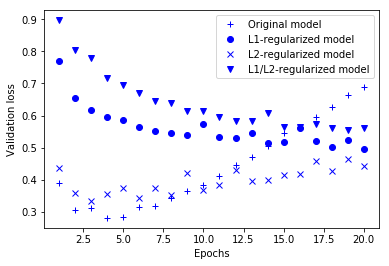

In [9]:
#Plot validation loss
l1_model_val_loss = l1_model_hist.history['val_loss']
l2_model_val_loss = l2_model_hist.history['val_loss']
l1_l2_model_val_loss = l1_l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l1_model_val_loss, 'bo', label='L1-regularized model')
plt.plot(epochs, l2_model_val_loss, 'bx', label='L2-regularized model')
plt.plot(epochs, l1_l2_model_val_loss, 'bv', label='L1/L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Now we experiment with dropout. We compare validation losses from different dropout rates. 

In [10]:
#Create three models with dropout rates of .2, .5, and .8

dpt2_model = models.Sequential()
dpt2_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt2_model.add(layers.Dropout(0.2))
dpt2_model.add(layers.Dense(16, activation='relu'))
dpt2_model.add(layers.Dropout(0.2))
dpt2_model.add(layers.Dense(1, activation='sigmoid'))

dpt2_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt2_model_hist = dpt2_model.fit(partial_x_train, partial_y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

dpt5_model = models.Sequential()
dpt5_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt5_model.add(layers.Dropout(0.5))
dpt5_model.add(layers.Dense(16, activation='relu'))
dpt5_model.add(layers.Dropout(0.5))
dpt5_model.add(layers.Dense(1, activation='sigmoid'))

dpt5_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt5_model_hist = dpt5_model.fit(partial_x_train, partial_y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

dpt8_model = models.Sequential()
dpt8_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt8_model.add(layers.Dropout(0.8))
dpt8_model.add(layers.Dense(16, activation='relu'))
dpt8_model.add(layers.Dropout(0.8))
dpt8_model.add(layers.Dense(1, activation='sigmoid'))

dpt8_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

dpt8_model_hist = dpt8_model.fit(partial_x_train, partial_y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

W0717 22:09:42.651504 139943469377408 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.5563 - acc: 0.7349 - val_loss: 0.4128 - val_acc: 0.8665
Epoch 2/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.3818 - acc: 0.8614 - val_loss: 0.3246 - val_acc: 0.8858
Epoch 3/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2925 - acc: 0.8993 - val_loss: 0.2882 - val_acc: 0.8900
Epoch 4/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2405 - acc: 0.9223 - val_loss: 0.2728 - val_acc: 0.8913
Epoch 5/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1997 - acc: 0.9335 - val_loss: 0.2811 - val_acc: 0.8857
Epoch 6/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1680 - acc: 0.9449 - val_loss: 0.2793 - val_acc: 0.8904
Epoch 7/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.1395 - acc: 0.9559 - val_loss: 0.2915 - val_ac

W0717 22:10:39.142354 139943469377408 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0717 22:10:39.173401 139943469377408 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 126us/step - loss: 0.6935 - acc: 0.5241 - val_loss: 0.6788 - val_acc: 0.6733
Epoch 2/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6821 - acc: 0.5459 - val_loss: 0.6570 - val_acc: 0.7564
Epoch 3/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6656 - acc: 0.5718 - val_loss: 0.6261 - val_acc: 0.8236
Epoch 4/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6408 - acc: 0.6087 - val_loss: 0.5902 - val_acc: 0.8425
Epoch 5/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6259 - acc: 0.6306 - val_loss: 0.5619 - val_acc: 0.8446
Epoch 6/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.6065 - acc: 0.6538 - val_loss: 0.5283 - val_acc: 0.8632
Epoch 7/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.5903 - acc: 0.6661 - val_loss: 0.5134 - val_ac

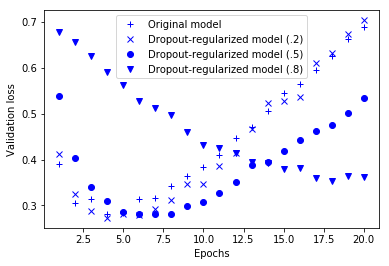

In [11]:
#Plot validation loss

dpt2_model_val_loss = dpt2_model_hist.history['val_loss']
dpt5_model_val_loss = dpt5_model_hist.history['val_loss']
dpt8_model_val_loss = dpt8_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt2_model_val_loss, 'bx', label='Dropout-regularized model (.2)')
plt.plot(epochs, dpt5_model_val_loss, 'bo', label='Dropout-regularized model (.5)')
plt.plot(epochs, dpt8_model_val_loss, 'bv', label='Dropout-regularized model (.8)')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Now we train a final version of the model (with both dropout and L2 regularization), validate to find optimal number of epochs, and test against the test data.

In [0]:
#Using .5 dropout rate and L2 regularization
final_model = models.Sequential()
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(max_words,)))
final_model.add(layers.Dropout(.5))
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
final_model.add(layers.Dropout(.5))
final_model.add(layers.Dense(1, activation='sigmoid'))

final_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [30]:
#Train model for 20 epochs
final_model_hist = final_model.fit(partial_x_train, partial_y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 163us/step - loss: 0.6507 - acc: 0.6685 - val_loss: 0.5316 - val_acc: 0.8571
Epoch 2/20
15000/15000 [==============================] - 1s 98us/step - loss: 0.5177 - acc: 0.7951 - val_loss: 0.4293 - val_acc: 0.8795
Epoch 3/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.4390 - acc: 0.8446 - val_loss: 0.3663 - val_acc: 0.8849
Epoch 4/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.3942 - acc: 0.8671 - val_loss: 0.3406 - val_acc: 0.8880
Epoch 5/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.3496 - acc: 0.8900 - val_loss: 0.3309 - val_acc: 0.8864
Epoch 6/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.3234 - acc: 0.9021 - val_loss: 0.3312 - val_acc: 0.8836
Epoch 7/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.3025 - acc: 0.9117 - val_loss: 0.3288 - val_ac

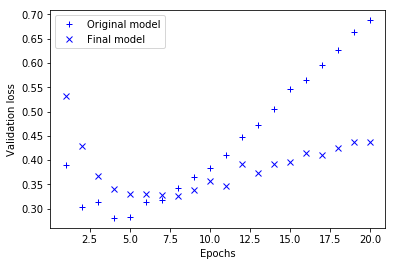

In [31]:
#Compare validation loss against original model
final_model_val_loss = final_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, final_model_val_loss, 'bx', label='Final model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [33]:
#Retrain final and original models to optimal number of epochs
model.fit(x_train, y_train, epochs=4, batch_size=512)
final_model.fit(x_train, y_train, epochs=8, batch_size=512)

Epoch 1/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.0094 - acc: 0.9980
Epoch 2/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.0049 - acc: 0.9995
Epoch 3/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.0068 - acc: 0.9988
Epoch 4/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.0038 - acc: 0.9997
Epoch 1/8
25000/25000 [==============================] - 1s 58us/step - loss: 0.3102 - acc: 0.9144
Epoch 2/8
25000/25000 [==============================] - 1s 57us/step - loss: 0.2781 - acc: 0.9235
Epoch 3/8
25000/25000 [==============================] - 1s 58us/step - loss: 0.2615 - acc: 0.9280
Epoch 4/8
25000/25000 [==============================] - 1s 58us/step - loss: 0.2594 - acc: 0.9302
Epoch 5/8
25000/25000 [==============================] - 1s 58us/step - loss: 0.2526 - acc: 0.9328
Epoch 6/8
25000/25000 [==============================] - 1s 58us/step - loss: 0.2461 - acc: 0.9340
Epoch 7/8


In [34]:
#Compare test data
original_results = model.evaluate(x_test, y_test)
final_results = final_model.evaluate(x_test, y_test)

print("Original model:", original_results)
print("Final model:", final_results)

25000/25000 [==============================] - 2s 84us/step
Original model: [1.1515536131596564, 0.84928]
Final model: [0.41878357303619385, 0.87628]
